In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

This code is to show how to optimize the parameter of the time-dependent OU processes based on MLE. This code has been vectorized so that it becomes possible to optimize a set of different sample paths at the same time

In [2]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

**Class: OU processes**

In [3]:
class tOU_vector:
    """
        simulate multiple trajectories at one-go via vectorisation;
        
    """
    
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN, D, timegrid = 'True'):
        """
        
        """
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        """
            # of trajectories you wish to sample
        """
        self.D = D
        if timegrid == 'True':
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
#             self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0].repeat(D,1)
        self.trj, self.dt = self.simulate()

    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
            outcome
                D by N matrices whose row corresponds to one independent time-dependent OU process
        """
        output = torch.empty(self.pts.shape)
        output[:,0] = self.z0.flatten()
        interval = self.pts[:, 1:] - self.pts[:, :-1]
        beta_t = self.alpha * ((( self.pts[:, :-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[:, 1:] + 1)**self.beta) - 1) + self.m0)
        for t in range(1, self.pts.shape[1]):
            # if the distance is too small, variance becomes 0
            mean = (output[:, t-1] - beta_t[:, t-1]) * torch.exp(-1 * self.r.flatten() * interval[:, t-1] )
            var = ((self.sigma ** 2 ) / (2*self.r.flatten())) * (1 - torch.exp(-2 * self.r.flatten() * interval[:, t-1]))
            if self.D > 1:
                output[:, t] = torch.from_numpy(ss.multivariate_normal.rvs(mean = mean, cov = torch.diag(var)))
            else:
                assert var > 0, "variance is negative, sd:%.3f interval: %.3f" % (var, interval[t-1] )
                output[:, t] = ss.norm.rvs(loc = mean, scale = np.sqrt(var))
            
        return [output, interval]

In [4]:
class MLE:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

We simulate two different sample paths from time-dependent OU processes, each of which has the same set of parameters except for $\alpha$ which has a different sign

In [5]:
alpha = torch.tensor([0.633, -0.633]).reshape(2, -1)
beta = torch.tensor([3.59, 3.59]).reshape(2, -1)
r = torch.tensor([1.124, 1.124]).reshape(2, -1)
m0 = torch.tensor([1.79, 1.79]).reshape(2, -1)

In [6]:
true_sde = tOU_vector(t0=0, t1=2, z0=m0, m0=m0, alpha=alpha, beta=beta, sigma=1, r=r, dN=40, D=2, timegrid = 'False')

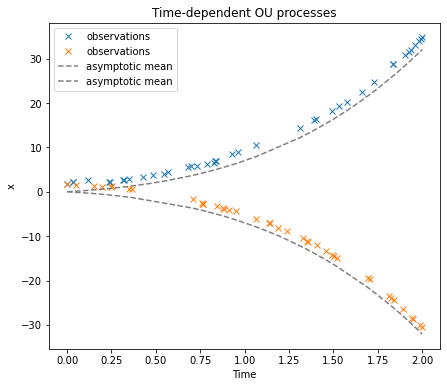

In [7]:
post_mean = lambda x: alpha * (((x + 1) ** beta) - 1) + 0
plt.figure(figsize=(7, 6))
plt.plot(true_sde.pts.T, true_sde.trj.T, 'x', label='observations')
plt.plot(true_sde.pts.T, post_mean(true_sde.pts).T, color='grey', linestyle='dashed', label='asymptotic mean')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Time-dependent OU processes")
plt.show()

We make inferences for the parameters of the above sample paths based on gradient descent algorithm. The algorithm is vectorized. 

Note: Gradient descent algorithm is sensitive to initaliziation, in partciular, the sign of $\alpha$. Hence, it is better to initialize $\alpha$ around 0 so that the algorithm finds the right "direction"*

In [8]:
beta_ = torch.tensor([0.5, 0.5], dtype=torch.float64).reshape(2,-1)
alpha_ = torch.tensor([0., 0.], dtype=torch.float64).reshape(2,-1)
r_ = torch.tensor([1., 1.], dtype=torch.float64).reshape(2,-1)

learning_rate = 0.000005
lr = learning_rate
for i in range(50000):
    mle = MLE(true_sde)
    update = mle.compute_score(beta = beta_, alpha=alpha_, m0=m0, r=r_)
    beta_ +=  learning_rate * update['beta']
    alpha_ += learning_rate * update['alpha']
    r__ = r_ + learning_rate * update['r']
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while any(r__ < 0):
        for d in range(r__.shape[0]):
            if r__[d] < 0:
                while r__[d] < 0:
                    r__[d] = r_[d] + lr * update['r'][d]
                    lr *= 0.5
    r_ = r__
        
    if i % 10000 == 0:
        print("beta = ", beta_.data.numpy(), 'alpha = ', alpha_.data.numpy(), 'r = ', r_.data.numpy())
        print("MLE = ", update['LNN'])

beta =  [[0.5]
 [0.5]] alpha =  [[ 0.00023445]
 [-0.0002286 ]] r =  [[0.99536559]
 [0.9955884 ]]
MLE =  [-1101.08760867 -1042.46180083]
beta =  [[1.64338073]
 [1.51948372]] alpha =  [[ 1.11549482]
 [-1.03829646]] r =  [[9.79184389e-04]
 [1.70622502e-07]]
MLE =  [-270.21518766 -266.91747838]
beta =  [[2.99424144]
 [2.99917627]] alpha =  [[ 1.36055444]
 [-1.33585623]] r =  [[8.01797213e-08]
 [4.05272610e-08]]
MLE =  [21.41563542 36.11250013]
beta =  [[3.19276124]
 [3.22014481]] alpha =  [[ 1.06298439]
 [-1.01523196]] r =  [[8.01797213e-08]
 [4.05272610e-08]]
MLE =  [23.99348514 39.16856505]
beta =  [[3.35807559]
 [3.40411961]] alpha =  [[ 0.86660209]
 [-0.80910412]] r =  [[8.01797213e-08]
 [4.05272610e-08]]
MLE =  [25.32958094 40.71873334]


Based on MLE estimator, we sample 50 different sample paths from the time-dependent OU. It is clear that these paths encaptulates our observations.

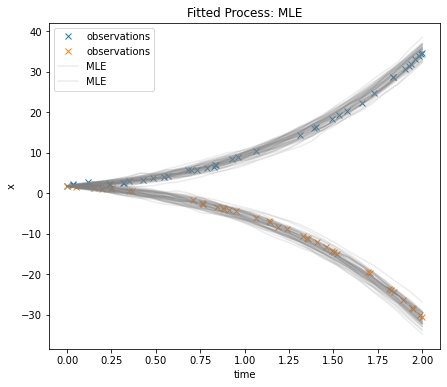

In [11]:
plt.figure(figsize=(7,6))
plt.title("Fitted Process: MLE")
plt.plot(true_sde.pts.T, true_sde.trj.T, 'x', label='observations')

for i in range(50):
    vi = tOU_vector(0, 2, m0, m0, alpha_, beta_, 1., r_, D=2, dN = 30)
    plt.plot(vi.pts.T, vi.trj.T, alpha=0.15, color='grey')
    if i == 49:
        plt.plot(vi.pts.T, vi.trj.T, alpha=0.15, color='grey', label='MLE')
plt.xlabel("time")
plt.ylabel("x")
plt.legend()
plt.show()

Variational inference: KL

In [67]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: -0.5 * (1-(r**2)) * z ** 2 + alpha * beta * (B(s, beta-1) + 1) * z \
                    -0.5 * ((r**2) - 1) * (alpha**2) * (beta**2) * B(s, 2*(beta-1)) \
                    -0.5 * (alpha * (B(s, beta) - 1) + m0 + r * alpha * beta * B(s, beta-1)) \
                    * (2 * z - alpha * (B(s, beta) - 1) - m0 - r * alpha * beta *B(s, beta - 1))
        
        num = func(self.ou.pts, self.ou.trj)

        return torch.trapezoid(abs(num), x=self.ou.pts).reshape(-1, 1)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = self.ou.D
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        t0 = self.ou.t0.clone().detach().repeat(D, 1)
        t1 = self.ou.t1.clone().detach().repeat(D, 1)
        
        # Obtain the rest 
        def A(s, u):
            return (r - 1) * 0.5 * (u ** 2) - u * r * alpha * (((s+1) ** beta) - 1) - r * m0 * u - alpha * beta * (s+1) * u
            
        return A(t1, z1) - A(t0, z0) - 0.5 * (r - 1) * (t1 - t0)
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.001)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1)))


In [68]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [69]:
true_sde = OU(t0 = 0, t1 = 6., z0 = 10, alpha = 0, beta = 1., sigma = 1., dN=601)

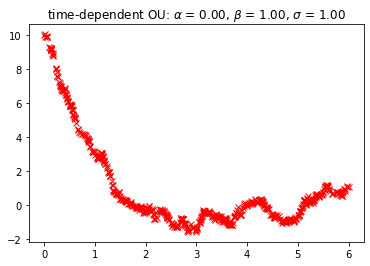

In [70]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title(r"time-dependent OU: $\alpha$ = %.2f" % true_sde.alpha + r", $\beta$ = %.2f" % true_sde.beta + r", $\sigma$ = %.2f" % true_sde.sigma)
plt.show()

In [71]:
obs = np.random.normal(loc = true_sde.trj[::100], scale = .001)
obs_time = true_sde.pts[::100]

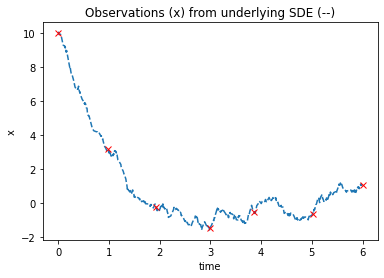

In [72]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [73]:
import tqdm as tq

In [89]:
D = 30

alpha_ = torch.tensor([0.])
beta_ = torch.rand(1)
r_ = torch.rand(1)

m0 = torch.tensor(obs[0]).repeat(D, 1)


learning_rate = 0.00000001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    alpha_D = alpha_.repeat(D, 1)
    beta_D = beta_.repeat(D, 1)
    r_D = r_.repeat(D, 1)
    
    # Compute (negative) ELBO
    vi_ = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=m0, m0=m0, alpha=alpha_D, beta=beta_D, sigma=1, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo_ = ELBO(vi_)
    elbo_estimate = -1 * (elbo.log_prob(torch.tensor(obs[1]).repeat(D, 1)) + elbo.KL_ito() + elbo.KL_rest())
    

    trace_pars.append((beta_.clone(), alpha_.clone(), r_.clone()))
    trace_elbo.append(torch.mean(elbo_estimate))
    
    # Obtain score function estimator of the gradient
    vi = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=m0, m0=m0, alpha=alpha_D, beta=beta_D, sigma=1, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo = ELBO(vi)
    score = Score(vi)

    scores = score.compute_score(alpha_D, beta_D, m0, r_D)
    f_of_X = -1 * (elbo.log_prob(torch.tensor(obs[1]).repeat(D, 1)) + elbo.KL_ito() + elbo.KL_rest())
#     print("f_of_X = ", f_of_X)
#     print("Scores = ", scores)
    beta_grad = torch.mean(f_of_X * scores['beta'])
    alpha_grad = torch.mean(f_of_X * scores['alpha'])
    r_grad = torch.mean(f_of_X * scores['r'])
#     print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)    
    beta_ -= learning_rate * beta_grad
    alpha_ -= learning_rate * alpha_grad
    r__ = r_ - learning_rate * r_grad
    
    print("beta = ", beta_, "alpha = ", alpha_, "r = ", r__)
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ - lr * r_grad
        lr *= 0.5
    r_ = r__
    
    if k % 100 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_, '(Negative) ELBO = ', torch.mean(elbo_estimate))
    
    
# score.compute_score()

  2%|▊                                          | 6/300 [00:00<00:05, 53.68it/s]

beta =  tensor([0.9213]) alpha =  tensor([-0.0530]) r =  tensor([0.7706])
beta =  tensor([0.9213]) alpha =  tensor([-0.0530]) r =  tensor([0.7706]) (Negative) ELBO =  tensor(236778.6291, dtype=torch.float64)
beta =  tensor([0.9286]) alpha =  tensor([-0.1550]) r =  tensor([0.7999])
beta =  tensor([0.9637]) alpha =  tensor([-0.3105]) r =  tensor([0.8287])
beta =  tensor([0.9568]) alpha =  tensor([-0.2954]) r =  tensor([0.8072])
beta =  tensor([1.0194]) alpha =  tensor([-0.4470]) r =  tensor([0.7921])
beta =  tensor([1.0533]) alpha =  tensor([-0.5089]) r =  tensor([0.7995])
beta =  tensor([1.0837]) alpha =  tensor([-0.5555]) r =  tensor([0.8203])
beta =  tensor([1.1162]) alpha =  tensor([-0.5939]) r =  tensor([0.8375])
beta =  tensor([1.1900]) alpha =  tensor([-0.6920]) r =  tensor([0.8453])
beta =  tensor([1.2571]) alpha =  tensor([-0.7730]) r =  tensor([0.8296])
beta =  tensor([1.3582]) alpha =  tensor([-0.8916]) r =  tensor([0.8687])
beta =  tensor([1.4219]) alpha =  tensor([-0.9415]) 

  7%|██▊                                       | 20/300 [00:00<00:04, 59.44it/s]

beta =  tensor([1.5739]) alpha =  tensor([-1.0846]) r =  tensor([0.8689])
beta =  tensor([1.8461]) alpha =  tensor([-1.3219]) r =  tensor([0.8796])
beta =  tensor([1.9855]) alpha =  tensor([-1.4232]) r =  tensor([0.8706])
beta =  tensor([2.0464]) alpha =  tensor([-1.4726]) r =  tensor([0.8715])
beta =  tensor([2.0984]) alpha =  tensor([-1.5165]) r =  tensor([0.8718])
beta =  tensor([2.1658]) alpha =  tensor([-1.5664]) r =  tensor([0.8698])
beta =  tensor([2.2567]) alpha =  tensor([-1.6319]) r =  tensor([0.8728])
beta =  tensor([2.2966]) alpha =  tensor([-1.6608]) r =  tensor([0.8733])
beta =  tensor([2.3298]) alpha =  tensor([-1.6835]) r =  tensor([0.8738])
beta =  tensor([2.3681]) alpha =  tensor([-1.7105]) r =  tensor([0.8762])
beta =  tensor([2.3566]) alpha =  tensor([-1.7022]) r =  tensor([0.8769])
beta =  tensor([2.3485]) alpha =  tensor([-1.6968]) r =  tensor([0.8797])
beta =  tensor([2.3310]) alpha =  tensor([-1.6853]) r =  tensor([0.8822])


 11%|████▌                                     | 33/300 [00:00<00:04, 59.48it/s]

beta =  tensor([2.3478]) alpha =  tensor([-1.6965]) r =  tensor([0.8830])
beta =  tensor([2.3175]) alpha =  tensor([-1.6762]) r =  tensor([0.8876])
beta =  tensor([2.3337]) alpha =  tensor([-1.6880]) r =  tensor([0.8894])
beta =  tensor([2.3636]) alpha =  tensor([-1.7065]) r =  tensor([0.8917])
beta =  tensor([2.3792]) alpha =  tensor([-1.7171]) r =  tensor([0.8932])
beta =  tensor([2.3831]) alpha =  tensor([-1.7210]) r =  tensor([0.8981])
beta =  tensor([2.3598]) alpha =  tensor([-1.7060]) r =  tensor([0.8986])
beta =  tensor([2.3411]) alpha =  tensor([-1.6944]) r =  tensor([0.8993])
beta =  tensor([2.3208]) alpha =  tensor([-1.6803]) r =  tensor([0.9016])
beta =  tensor([2.3314]) alpha =  tensor([-1.6877]) r =  tensor([0.9025])
beta =  tensor([2.3362]) alpha =  tensor([-1.6915]) r =  tensor([0.9044])
beta =  tensor([2.3340]) alpha =  tensor([-1.6896]) r =  tensor([0.9058])


 15%|██████▎                                   | 45/300 [00:00<00:04, 59.05it/s]

beta =  tensor([2.3591]) alpha =  tensor([-1.7065]) r =  tensor([0.9069])
beta =  tensor([2.3646]) alpha =  tensor([-1.7094]) r =  tensor([0.9083])
beta =  tensor([2.3634]) alpha =  tensor([-1.7082]) r =  tensor([0.9117])
beta =  tensor([2.3662]) alpha =  tensor([-1.7106]) r =  tensor([0.9127])
beta =  tensor([2.3681]) alpha =  tensor([-1.7133]) r =  tensor([0.9138])
beta =  tensor([2.3712]) alpha =  tensor([-1.7150]) r =  tensor([0.9165])
beta =  tensor([2.3661]) alpha =  tensor([-1.7117]) r =  tensor([0.9171])
beta =  tensor([2.3591]) alpha =  tensor([-1.7070]) r =  tensor([0.9178])
beta =  tensor([2.3456]) alpha =  tensor([-1.6981]) r =  tensor([0.9188])
beta =  tensor([2.3669]) alpha =  tensor([-1.7112]) r =  tensor([0.9220])
beta =  tensor([2.3444]) alpha =  tensor([-1.6961]) r =  tensor([0.9232])
beta =  tensor([2.3609]) alpha =  tensor([-1.7076]) r =  tensor([0.9241])


 19%|███████▉                                  | 57/300 [00:00<00:04, 58.88it/s]

beta =  tensor([2.3612]) alpha =  tensor([-1.7077]) r =  tensor([0.9247])
beta =  tensor([2.3268]) alpha =  tensor([-1.6849]) r =  tensor([0.9263])
beta =  tensor([2.3395]) alpha =  tensor([-1.6937]) r =  tensor([0.9271])
beta =  tensor([2.3127]) alpha =  tensor([-1.6752]) r =  tensor([0.9289])
beta =  tensor([2.3368]) alpha =  tensor([-1.6921]) r =  tensor([0.9302])
beta =  tensor([2.3441]) alpha =  tensor([-1.6970]) r =  tensor([0.9308])
beta =  tensor([2.3340]) alpha =  tensor([-1.6898]) r =  tensor([0.9321])
beta =  tensor([2.3536]) alpha =  tensor([-1.7034]) r =  tensor([0.9342])
beta =  tensor([2.3772]) alpha =  tensor([-1.7187]) r =  tensor([0.9366])
beta =  tensor([2.3789]) alpha =  tensor([-1.7195]) r =  tensor([0.9394])
beta =  tensor([2.3556]) alpha =  tensor([-1.7035]) r =  tensor([0.9403])
beta =  tensor([2.3839]) alpha =  tensor([-1.7232]) r =  tensor([0.9431])


 24%|█████████▉                                | 71/300 [00:01<00:03, 60.16it/s]

beta =  tensor([2.3912]) alpha =  tensor([-1.7283]) r =  tensor([0.9451])
beta =  tensor([2.3650]) alpha =  tensor([-1.7113]) r =  tensor([0.9459])
beta =  tensor([2.3746]) alpha =  tensor([-1.7167]) r =  tensor([0.9477])
beta =  tensor([2.3496]) alpha =  tensor([-1.6998]) r =  tensor([0.9499])
beta =  tensor([2.3518]) alpha =  tensor([-1.7016]) r =  tensor([0.9522])
beta =  tensor([2.3670]) alpha =  tensor([-1.7115]) r =  tensor([0.9537])
beta =  tensor([2.3758]) alpha =  tensor([-1.7181]) r =  tensor([0.9556])
beta =  tensor([2.3517]) alpha =  tensor([-1.7008]) r =  tensor([0.9586])
beta =  tensor([2.3455]) alpha =  tensor([-1.6966]) r =  tensor([0.9593])
beta =  tensor([2.3597]) alpha =  tensor([-1.7058]) r =  tensor([0.9598])
beta =  tensor([2.3597]) alpha =  tensor([-1.7059]) r =  tensor([0.9612])
beta =  tensor([2.3660]) alpha =  tensor([-1.7108]) r =  tensor([0.9626])
beta =  tensor([2.3692]) alpha =  tensor([-1.7132]) r =  tensor([0.9658])


 28%|███████████▉                              | 85/300 [00:01<00:03, 60.56it/s]

beta =  tensor([2.3535]) alpha =  tensor([-1.7028]) r =  tensor([0.9666])
beta =  tensor([2.3430]) alpha =  tensor([-1.6957]) r =  tensor([0.9685])
beta =  tensor([2.3546]) alpha =  tensor([-1.7036]) r =  tensor([0.9699])
beta =  tensor([2.3641]) alpha =  tensor([-1.7102]) r =  tensor([0.9710])
beta =  tensor([2.3580]) alpha =  tensor([-1.7062]) r =  tensor([0.9718])
beta =  tensor([2.3387]) alpha =  tensor([-1.6922]) r =  tensor([0.9730])
beta =  tensor([2.3411]) alpha =  tensor([-1.6931]) r =  tensor([0.9742])
beta =  tensor([2.3478]) alpha =  tensor([-1.6981]) r =  tensor([0.9749])
beta =  tensor([2.3532]) alpha =  tensor([-1.7016]) r =  tensor([0.9768])
beta =  tensor([2.3613]) alpha =  tensor([-1.7078]) r =  tensor([0.9783])
beta =  tensor([2.3532]) alpha =  tensor([-1.7022]) r =  tensor([0.9801])
beta =  tensor([2.3784]) alpha =  tensor([-1.7187]) r =  tensor([0.9850])
beta =  tensor([2.3569]) alpha =  tensor([-1.7046]) r =  tensor([0.9857])


 33%|█████████████▋                            | 98/300 [00:01<00:03, 59.37it/s]

beta =  tensor([2.3764]) alpha =  tensor([-1.7174]) r =  tensor([0.9867])
beta =  tensor([2.3779]) alpha =  tensor([-1.7192]) r =  tensor([0.9893])
beta =  tensor([2.3715]) alpha =  tensor([-1.7148]) r =  tensor([0.9902])
beta =  tensor([2.3597]) alpha =  tensor([-1.7069]) r =  tensor([0.9906])
beta =  tensor([2.3551]) alpha =  tensor([-1.7037]) r =  tensor([0.9923])
beta =  tensor([2.3448]) alpha =  tensor([-1.6964]) r =  tensor([0.9952])
beta =  tensor([2.3479]) alpha =  tensor([-1.6978]) r =  tensor([0.9964])
beta =  tensor([2.3537]) alpha =  tensor([-1.7017]) r =  tensor([0.9969])
beta =  tensor([2.3530]) alpha =  tensor([-1.7013]) r =  tensor([0.9971])
beta =  tensor([2.3610]) alpha =  tensor([-1.7061]) r =  tensor([0.9988])
beta =  tensor([2.3717]) alpha =  tensor([-1.7130]) r =  tensor([0.9995])
beta =  tensor([2.3671]) alpha =  tensor([-1.7102]) r =  tensor([0.9997])


 37%|███████████████▏                         | 111/300 [00:01<00:03, 59.80it/s]

beta =  tensor([2.3560]) alpha =  tensor([-1.7031]) r =  tensor([1.0024])
beta =  tensor([2.3435]) alpha =  tensor([-1.6945]) r =  tensor([1.0042])
beta =  tensor([2.3435]) alpha =  tensor([-1.6945]) r =  tensor([1.0042]) (Negative) ELBO =  tensor(306017.9711, dtype=torch.float64)
beta =  tensor([2.3472]) alpha =  tensor([-1.6972]) r =  tensor([1.0048])
beta =  tensor([2.3579]) alpha =  tensor([-1.7042]) r =  tensor([1.0056])
beta =  tensor([2.3367]) alpha =  tensor([-1.6901]) r =  tensor([1.0066])
beta =  tensor([2.3434]) alpha =  tensor([-1.6947]) r =  tensor([1.0070])
beta =  tensor([2.3359]) alpha =  tensor([-1.6900]) r =  tensor([1.0072])
beta =  tensor([2.3626]) alpha =  tensor([-1.7070]) r =  tensor([1.0103])
beta =  tensor([2.3564]) alpha =  tensor([-1.7024]) r =  tensor([1.0131])
beta =  tensor([2.3515]) alpha =  tensor([-1.6979]) r =  tensor([1.0158])
beta =  tensor([2.3415]) alpha =  tensor([-1.6906]) r =  tensor([1.0168])
beta =  tensor([2.3752]) alpha =  tensor([-1.7119]) 

 42%|█████████████████                        | 125/300 [00:02<00:02, 60.81it/s]

beta =  tensor([2.3669]) alpha =  tensor([-1.7064]) r =  tensor([1.0229])
beta =  tensor([2.3781]) alpha =  tensor([-1.7144]) r =  tensor([1.0259])
beta =  tensor([2.3546]) alpha =  tensor([-1.6980]) r =  tensor([1.0279])
beta =  tensor([2.3820]) alpha =  tensor([-1.7171]) r =  tensor([1.0304])
beta =  tensor([2.3810]) alpha =  tensor([-1.7170]) r =  tensor([1.0311])
beta =  tensor([2.3658]) alpha =  tensor([-1.7065]) r =  tensor([1.0313])
beta =  tensor([2.3399]) alpha =  tensor([-1.6883]) r =  tensor([1.0334])
beta =  tensor([2.3635]) alpha =  tensor([-1.7057]) r =  tensor([1.0356])
beta =  tensor([2.3582]) alpha =  tensor([-1.7018]) r =  tensor([1.0374])
beta =  tensor([2.3644]) alpha =  tensor([-1.7066]) r =  tensor([1.0386])
beta =  tensor([2.3743]) alpha =  tensor([-1.7131]) r =  tensor([1.0391])
beta =  tensor([2.3700]) alpha =  tensor([-1.7090]) r =  tensor([1.0400])
beta =  tensor([2.3573]) alpha =  tensor([-1.7001]) r =  tensor([1.0423])


 44%|██████████████████                       | 132/300 [00:02<00:02, 61.29it/s]

beta =  tensor([2.3742]) alpha =  tensor([-1.7112]) r =  tensor([1.0427])
beta =  tensor([2.3597]) alpha =  tensor([-1.7006]) r =  tensor([1.0444])
beta =  tensor([2.3694]) alpha =  tensor([-1.7070]) r =  tensor([1.0462])
beta =  tensor([2.3513]) alpha =  tensor([-1.6941]) r =  tensor([1.0473])
beta =  tensor([2.3448]) alpha =  tensor([-1.6904]) r =  tensor([1.0482])
beta =  tensor([2.3450]) alpha =  tensor([-1.6903]) r =  tensor([1.0490])
beta =  tensor([2.3704]) alpha =  tensor([-1.7079]) r =  tensor([1.0509])
beta =  tensor([2.3645]) alpha =  tensor([-1.7041]) r =  tensor([1.0538])
beta =  tensor([2.3606]) alpha =  tensor([-1.7018]) r =  tensor([1.0540])
beta =  tensor([2.3623]) alpha =  tensor([-1.7031]) r =  tensor([1.0542])
beta =  tensor([2.3626]) alpha =  tensor([-1.7028]) r =  tensor([1.0542])
beta =  tensor([2.3773]) alpha =  tensor([-1.7128]) r =  tensor([1.0558])
beta =  tensor([2.3633]) alpha =  tensor([-1.7027]) r =  tensor([1.0579])


 49%|███████████████████▉                     | 146/300 [00:02<00:02, 61.90it/s]

beta =  tensor([2.3448]) alpha =  tensor([-1.6893]) r =  tensor([1.0614])
beta =  tensor([2.3409]) alpha =  tensor([-1.6863]) r =  tensor([1.0620])
beta =  tensor([2.3434]) alpha =  tensor([-1.6884]) r =  tensor([1.0631])
beta =  tensor([2.3423]) alpha =  tensor([-1.6879]) r =  tensor([1.0641])
beta =  tensor([2.3388]) alpha =  tensor([-1.6852]) r =  tensor([1.0642])
beta =  tensor([2.3376]) alpha =  tensor([-1.6839]) r =  tensor([1.0649])
beta =  tensor([2.3715]) alpha =  tensor([-1.7083]) r =  tensor([1.0714])
beta =  tensor([2.3897]) alpha =  tensor([-1.7216]) r =  tensor([1.0734])
beta =  tensor([2.3854]) alpha =  tensor([-1.7180]) r =  tensor([1.0752])
beta =  tensor([2.3840]) alpha =  tensor([-1.7177]) r =  tensor([1.0759])
beta =  tensor([2.3525]) alpha =  tensor([-1.6956]) r =  tensor([1.0791])
beta =  tensor([2.3575]) alpha =  tensor([-1.6982]) r =  tensor([1.0808])
beta =  tensor([2.3599]) alpha =  tensor([-1.6997]) r =  tensor([1.0812])


 53%|█████████████████████▊                   | 160/300 [00:02<00:02, 62.35it/s]

beta =  tensor([2.3592]) alpha =  tensor([-1.6992]) r =  tensor([1.0825])
beta =  tensor([2.3691]) alpha =  tensor([-1.7056]) r =  tensor([1.0831])
beta =  tensor([2.3721]) alpha =  tensor([-1.7073]) r =  tensor([1.0843])
beta =  tensor([2.3529]) alpha =  tensor([-1.6940]) r =  tensor([1.0852])
beta =  tensor([2.3584]) alpha =  tensor([-1.6975]) r =  tensor([1.0857])
beta =  tensor([2.3371]) alpha =  tensor([-1.6840]) r =  tensor([1.0873])
beta =  tensor([2.3332]) alpha =  tensor([-1.6814]) r =  tensor([1.0885])
beta =  tensor([2.3428]) alpha =  tensor([-1.6883]) r =  tensor([1.0887])
beta =  tensor([2.3717]) alpha =  tensor([-1.7083]) r =  tensor([1.0904])
beta =  tensor([2.3660]) alpha =  tensor([-1.7050]) r =  tensor([1.0907])
beta =  tensor([2.3433]) alpha =  tensor([-1.6894]) r =  tensor([1.0932])
beta =  tensor([2.3406]) alpha =  tensor([-1.6876]) r =  tensor([1.0936])
beta =  tensor([2.3616]) alpha =  tensor([-1.7024]) r =  tensor([1.0952])


 58%|███████████████████████▊                 | 174/300 [00:02<00:02, 60.89it/s]

beta =  tensor([2.3470]) alpha =  tensor([-1.6913]) r =  tensor([1.0966])
beta =  tensor([2.3557]) alpha =  tensor([-1.6972]) r =  tensor([1.0973])
beta =  tensor([2.3402]) alpha =  tensor([-1.6867]) r =  tensor([1.0994])
beta =  tensor([2.3614]) alpha =  tensor([-1.6998]) r =  tensor([1.1012])
beta =  tensor([2.3726]) alpha =  tensor([-1.7082]) r =  tensor([1.1024])
beta =  tensor([2.3921]) alpha =  tensor([-1.7213]) r =  tensor([1.1064])
beta =  tensor([2.3878]) alpha =  tensor([-1.7182]) r =  tensor([1.1073])
beta =  tensor([2.3626]) alpha =  tensor([-1.7016]) r =  tensor([1.1081])
beta =  tensor([2.3664]) alpha =  tensor([-1.7052]) r =  tensor([1.1105])
beta =  tensor([2.3637]) alpha =  tensor([-1.7038]) r =  tensor([1.1120])
beta =  tensor([2.3524]) alpha =  tensor([-1.6967]) r =  tensor([1.1130])
beta =  tensor([2.3486]) alpha =  tensor([-1.6928]) r =  tensor([1.1156])


 63%|█████████████████████████▋               | 188/300 [00:03<00:01, 60.67it/s]

beta =  tensor([2.3869]) alpha =  tensor([-1.7186]) r =  tensor([1.1185])
beta =  tensor([2.3785]) alpha =  tensor([-1.7124]) r =  tensor([1.1201])
beta =  tensor([2.3363]) alpha =  tensor([-1.6857]) r =  tensor([1.1216])
beta =  tensor([2.3644]) alpha =  tensor([-1.7050]) r =  tensor([1.1247])
beta =  tensor([2.3555]) alpha =  tensor([-1.6985]) r =  tensor([1.1251])
beta =  tensor([2.3817]) alpha =  tensor([-1.7162]) r =  tensor([1.1277])
beta =  tensor([2.3562]) alpha =  tensor([-1.6988]) r =  tensor([1.1288])
beta =  tensor([2.3578]) alpha =  tensor([-1.6995]) r =  tensor([1.1295])
beta =  tensor([2.3704]) alpha =  tensor([-1.7084]) r =  tensor([1.1310])
beta =  tensor([2.3441]) alpha =  tensor([-1.6911]) r =  tensor([1.1322])
beta =  tensor([2.3315]) alpha =  tensor([-1.6824]) r =  tensor([1.1334])
beta =  tensor([2.3429]) alpha =  tensor([-1.6903]) r =  tensor([1.1336])
beta =  tensor([2.3637]) alpha =  tensor([-1.7059]) r =  tensor([1.1356])


 67%|███████████████████████████▌             | 202/300 [00:03<00:01, 60.71it/s]

beta =  tensor([2.3746]) alpha =  tensor([-1.7136]) r =  tensor([1.1362])
beta =  tensor([2.3671]) alpha =  tensor([-1.7072]) r =  tensor([1.1391])
beta =  tensor([2.3541]) alpha =  tensor([-1.6979]) r =  tensor([1.1410])
beta =  tensor([2.3626]) alpha =  tensor([-1.7031]) r =  tensor([1.1416])
beta =  tensor([2.3599]) alpha =  tensor([-1.7011]) r =  tensor([1.1420])
beta =  tensor([2.3502]) alpha =  tensor([-1.6944]) r =  tensor([1.1426])
beta =  tensor([2.3564]) alpha =  tensor([-1.6994]) r =  tensor([1.1435])
beta =  tensor([2.3658]) alpha =  tensor([-1.7057]) r =  tensor([1.1449])
beta =  tensor([2.3530]) alpha =  tensor([-1.6969]) r =  tensor([1.1463])
beta =  tensor([2.3678]) alpha =  tensor([-1.7069]) r =  tensor([1.1467])
beta =  tensor([2.3483]) alpha =  tensor([-1.6928]) r =  tensor([1.1478])
beta =  tensor([2.3513]) alpha =  tensor([-1.6957]) r =  tensor([1.1487])
beta =  tensor([2.3513]) alpha =  tensor([-1.6957]) r =  tensor([1.1487]) (Negative) ELBO =  tensor(216879.2944,

 70%|████████████████████████████▌            | 209/300 [00:03<00:01, 61.18it/s]

beta =  tensor([2.3482]) alpha =  tensor([-1.6935]) r =  tensor([1.1504])
beta =  tensor([2.3390]) alpha =  tensor([-1.6865]) r =  tensor([1.1522])
beta =  tensor([2.3290]) alpha =  tensor([-1.6790]) r =  tensor([1.1543])
beta =  tensor([2.3316]) alpha =  tensor([-1.6812]) r =  tensor([1.1543])
beta =  tensor([2.3370]) alpha =  tensor([-1.6847]) r =  tensor([1.1553])
beta =  tensor([2.3594]) alpha =  tensor([-1.7016]) r =  tensor([1.1574])
beta =  tensor([2.3608]) alpha =  tensor([-1.7027]) r =  tensor([1.1577])
beta =  tensor([2.3588]) alpha =  tensor([-1.7014]) r =  tensor([1.1579])
beta =  tensor([2.3865]) alpha =  tensor([-1.7204]) r =  tensor([1.1612])
beta =  tensor([2.3752]) alpha =  tensor([-1.7136]) r =  tensor([1.1614])
beta =  tensor([2.3558]) alpha =  tensor([-1.7005]) r =  tensor([1.1618])
beta =  tensor([2.3514]) alpha =  tensor([-1.6974]) r =  tensor([1.1627])
beta =  tensor([2.3625]) alpha =  tensor([-1.7049]) r =  tensor([1.1632])


 74%|██████████████████████████████▍          | 223/300 [00:03<00:01, 60.56it/s]

beta =  tensor([2.3546]) alpha =  tensor([-1.7004]) r =  tensor([1.1636])
beta =  tensor([2.3501]) alpha =  tensor([-1.6973]) r =  tensor([1.1643])
beta =  tensor([2.3496]) alpha =  tensor([-1.6969]) r =  tensor([1.1650])
beta =  tensor([2.3381]) alpha =  tensor([-1.6892]) r =  tensor([1.1666])
beta =  tensor([2.3500]) alpha =  tensor([-1.6965]) r =  tensor([1.1677])
beta =  tensor([2.3494]) alpha =  tensor([-1.6961]) r =  tensor([1.1684])
beta =  tensor([2.3535]) alpha =  tensor([-1.6995]) r =  tensor([1.1689])
beta =  tensor([2.3723]) alpha =  tensor([-1.7120]) r =  tensor([1.1702])
beta =  tensor([2.3531]) alpha =  tensor([-1.6986]) r =  tensor([1.1713])
beta =  tensor([2.3372]) alpha =  tensor([-1.6877]) r =  tensor([1.1722])
beta =  tensor([2.3414]) alpha =  tensor([-1.6904]) r =  tensor([1.1731])
beta =  tensor([2.3378]) alpha =  tensor([-1.6883]) r =  tensor([1.1744])


 79%|████████████████████████████████▎        | 236/300 [00:03<00:01, 59.11it/s]

beta =  tensor([2.3336]) alpha =  tensor([-1.6848]) r =  tensor([1.1753])
beta =  tensor([2.3346]) alpha =  tensor([-1.6857]) r =  tensor([1.1756])
beta =  tensor([2.3489]) alpha =  tensor([-1.6954]) r =  tensor([1.1763])
beta =  tensor([2.3547]) alpha =  tensor([-1.6985]) r =  tensor([1.1773])
beta =  tensor([2.3688]) alpha =  tensor([-1.7088]) r =  tensor([1.1783])
beta =  tensor([2.3707]) alpha =  tensor([-1.7105]) r =  tensor([1.1795])
beta =  tensor([2.3658]) alpha =  tensor([-1.7076]) r =  tensor([1.1806])
beta =  tensor([2.3627]) alpha =  tensor([-1.7051]) r =  tensor([1.1813])
beta =  tensor([2.3497]) alpha =  tensor([-1.6968]) r =  tensor([1.1820])
beta =  tensor([2.3406]) alpha =  tensor([-1.6909]) r =  tensor([1.1830])
beta =  tensor([2.3401]) alpha =  tensor([-1.6909]) r =  tensor([1.1833])
beta =  tensor([2.3447]) alpha =  tensor([-1.6932]) r =  tensor([1.1853])


 83%|██████████████████████████████████       | 249/300 [00:04<00:00, 59.90it/s]

beta =  tensor([2.3440]) alpha =  tensor([-1.6932]) r =  tensor([1.1860])
beta =  tensor([2.3498]) alpha =  tensor([-1.6968]) r =  tensor([1.1863])
beta =  tensor([2.3768]) alpha =  tensor([-1.7163]) r =  tensor([1.1883])
beta =  tensor([2.3744]) alpha =  tensor([-1.7138]) r =  tensor([1.1894])
beta =  tensor([2.3876]) alpha =  tensor([-1.7226]) r =  tensor([1.1908])
beta =  tensor([2.3780]) alpha =  tensor([-1.7167]) r =  tensor([1.1934])
beta =  tensor([2.3745]) alpha =  tensor([-1.7133]) r =  tensor([1.1944])
beta =  tensor([2.3842]) alpha =  tensor([-1.7200]) r =  tensor([1.1961])
beta =  tensor([2.3849]) alpha =  tensor([-1.7207]) r =  tensor([1.1971])
beta =  tensor([2.3781]) alpha =  tensor([-1.7162]) r =  tensor([1.1983])
beta =  tensor([2.3791]) alpha =  tensor([-1.7171]) r =  tensor([1.1992])
beta =  tensor([2.3813]) alpha =  tensor([-1.7185]) r =  tensor([1.1993])
beta =  tensor([2.3725]) alpha =  tensor([-1.7128]) r =  tensor([1.1995])


 87%|███████████████████████████████████▋     | 261/300 [00:04<00:00, 59.33it/s]

beta =  tensor([2.3568]) alpha =  tensor([-1.7019]) r =  tensor([1.2001])
beta =  tensor([2.3379]) alpha =  tensor([-1.6901]) r =  tensor([1.2010])
beta =  tensor([2.3463]) alpha =  tensor([-1.6956]) r =  tensor([1.2014])
beta =  tensor([2.3585]) alpha =  tensor([-1.7033]) r =  tensor([1.2016])
beta =  tensor([2.3331]) alpha =  tensor([-1.6860]) r =  tensor([1.2040])
beta =  tensor([2.3622]) alpha =  tensor([-1.7046]) r =  tensor([1.2057])
beta =  tensor([2.3441]) alpha =  tensor([-1.6928]) r =  tensor([1.2073])
beta =  tensor([2.3514]) alpha =  tensor([-1.6983]) r =  tensor([1.2084])
beta =  tensor([2.3623]) alpha =  tensor([-1.7060]) r =  tensor([1.2086])
beta =  tensor([2.3630]) alpha =  tensor([-1.7069]) r =  tensor([1.2095])
beta =  tensor([2.3441]) alpha =  tensor([-1.6940]) r =  tensor([1.2106])
beta =  tensor([2.3446]) alpha =  tensor([-1.6944]) r =  tensor([1.2108])


 91%|█████████████████████████████████████▎   | 273/300 [00:04<00:00, 58.28it/s]

beta =  tensor([2.3471]) alpha =  tensor([-1.6961]) r =  tensor([1.2113])
beta =  tensor([2.3386]) alpha =  tensor([-1.6903]) r =  tensor([1.2120])
beta =  tensor([2.3605]) alpha =  tensor([-1.7050]) r =  tensor([1.2127])
beta =  tensor([2.3415]) alpha =  tensor([-1.6921]) r =  tensor([1.2143])
beta =  tensor([2.3417]) alpha =  tensor([-1.6920]) r =  tensor([1.2147])
beta =  tensor([2.3487]) alpha =  tensor([-1.6954]) r =  tensor([1.2173])
beta =  tensor([2.3546]) alpha =  tensor([-1.6996]) r =  tensor([1.2183])
beta =  tensor([2.3511]) alpha =  tensor([-1.6973]) r =  tensor([1.2189])
beta =  tensor([2.3669]) alpha =  tensor([-1.7079]) r =  tensor([1.2195])
beta =  tensor([2.3543]) alpha =  tensor([-1.6998]) r =  tensor([1.2206])
beta =  tensor([2.3656]) alpha =  tensor([-1.7074]) r =  tensor([1.2209])
beta =  tensor([2.3389]) alpha =  tensor([-1.6901]) r =  tensor([1.2216])


 96%|███████████████████████████████████████▏ | 287/300 [00:04<00:00, 60.01it/s]

beta =  tensor([2.3465]) alpha =  tensor([-1.6954]) r =  tensor([1.2220])
beta =  tensor([2.3551]) alpha =  tensor([-1.7011]) r =  tensor([1.2225])
beta =  tensor([2.3585]) alpha =  tensor([-1.7030]) r =  tensor([1.2233])
beta =  tensor([2.3517]) alpha =  tensor([-1.6982]) r =  tensor([1.2237])
beta =  tensor([2.3375]) alpha =  tensor([-1.6892]) r =  tensor([1.2245])
beta =  tensor([2.3469]) alpha =  tensor([-1.6958]) r =  tensor([1.2253])
beta =  tensor([2.3580]) alpha =  tensor([-1.7032]) r =  tensor([1.2263])
beta =  tensor([2.3670]) alpha =  tensor([-1.7096]) r =  tensor([1.2277])
beta =  tensor([2.3727]) alpha =  tensor([-1.7135]) r =  tensor([1.2277])
beta =  tensor([2.3776]) alpha =  tensor([-1.7166]) r =  tensor([1.2281])
beta =  tensor([2.3614]) alpha =  tensor([-1.7057]) r =  tensor([1.2290])
beta =  tensor([2.3816]) alpha =  tensor([-1.7195]) r =  tensor([1.2301])
beta =  tensor([2.3451]) alpha =  tensor([-1.6933]) r =  tensor([1.2330])


100%|█████████████████████████████████████████| 300/300 [00:04<00:00, 60.08it/s]

beta =  tensor([2.3700]) alpha =  tensor([-1.7104]) r =  tensor([1.2346])
beta =  tensor([2.3461]) alpha =  tensor([-1.6940]) r =  tensor([1.2355])
beta =  tensor([2.3566]) alpha =  tensor([-1.7012]) r =  tensor([1.2366])
beta =  tensor([2.3559]) alpha =  tensor([-1.7006]) r =  tensor([1.2372])
beta =  tensor([2.3640]) alpha =  tensor([-1.7059]) r =  tensor([1.2376])
beta =  tensor([2.3530]) alpha =  tensor([-1.6989]) r =  tensor([1.2379])
beta =  tensor([2.3638]) alpha =  tensor([-1.7064]) r =  tensor([1.2395])
beta =  tensor([2.3586]) alpha =  tensor([-1.7029]) r =  tensor([1.2405])
beta =  tensor([2.3528]) alpha =  tensor([-1.6993]) r =  tensor([1.2407])
beta =  tensor([2.3549]) alpha =  tensor([-1.7002]) r =  tensor([1.2410])
beta =  tensor([2.3660]) alpha =  tensor([-1.7077]) r =  tensor([1.2417])


**Posterior mean**

In [90]:
post_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0[0]

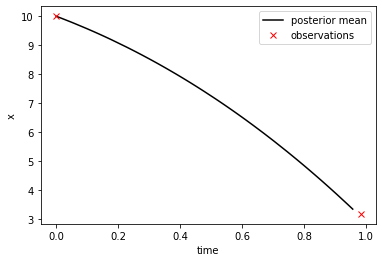

In [91]:
# plt.plot(true_sde.pts[:100], true_mean(true_sde.pts)[:100], color='r', alpha=0.3, linestyle='dashed', label="true mean")
plt.plot(true_sde.pts[:100], post_mean(true_sde.pts)[:100], color='black', label="posterior mean")
plt.plot(true_sde.pts[::100][:2], obs[:2], 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

tensor([9.9985], dtype=torch.float64)

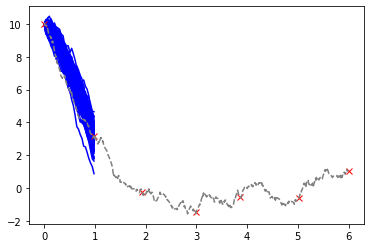

In [129]:
S = 100
posterior = tOU_vector(t0 = obs_time[0], t1 = obs_time[1], z0 = m0[0].repeat(S, 1), m0 = m0[0].repeat(S, 1), alpha = alpha_, beta = beta_, sigma = 1, r = r_, D = S, dN = 30, timegrid='True')
plt.plot(posterior.pts.T, posterior.trj.T, 'b')
plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

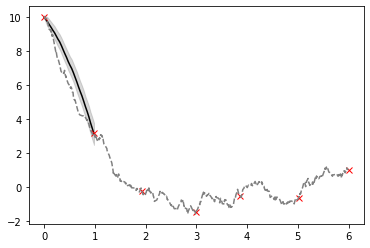

In [136]:
post_mean = torch.mean(posterior.trj, axis=0)
post_std = torch.std(posterior.trj, axis=0)

plt.plot(posterior.pts[0], post_mean, color='black')
plt.fill_between(posterior.pts[0], post_mean + post_std, post_mean - post_std, color='grey', alpha=0.3)
plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

**Trace plot: gradient**

In [96]:
par[0].data.numpy()

array([0.8015143], dtype=float32)

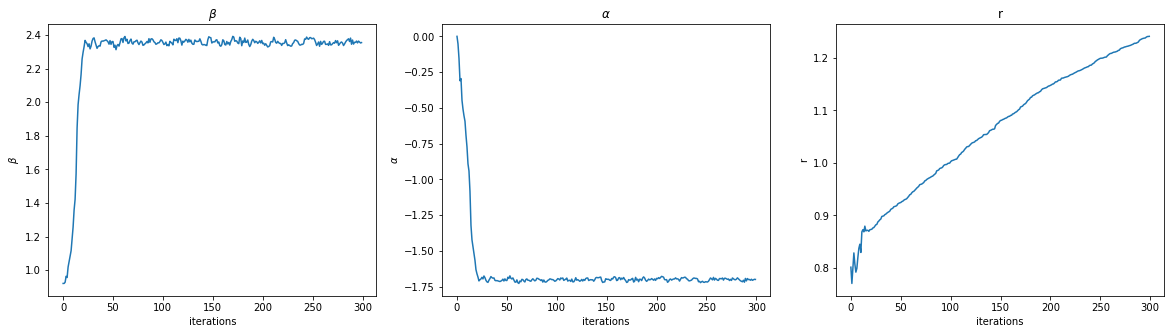

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
names = [r'$\beta$', r'$\alpha$', 'r']
for i, ax in enumerate(ax.ravel()):
    par = [item[i].data.numpy() for item in trace_pars]
    ax.plot(np.arange(len(par)), par)
    ax.set_title(names[i])
    ax.set_xlabel('iterations')
    ax.set_ylabel(names[i])
# plt.title("Trace plot: beta")
# plt.plot(np.arange(len(betas)), betas)
# plt.xlabel("iteration")
# plt.ylabel(r"$\beta$")
# plt.show()

**Trace plot: ELBO**

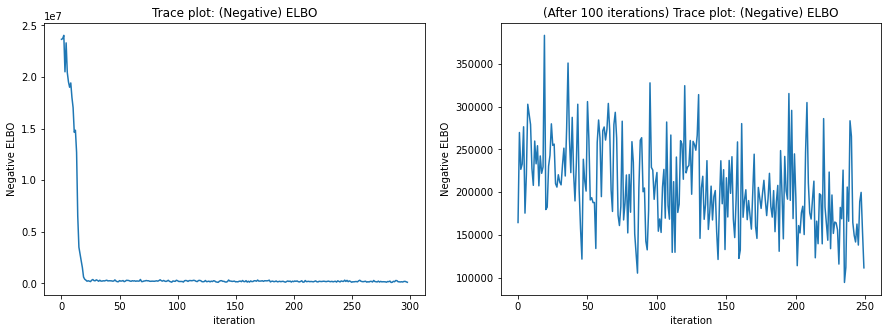

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, ax in enumerate(ax.ravel()):
    ax.set_title("Trace plot: (Negative) ELBO")
    if i == 0:
        ax.plot(np.arange(len(trace_elbo[1:])), trace_elbo[1:])
    else:
        ax.plot(np.arange(len(trace_elbo[50:])), trace_elbo[50:])
        ax.set_title("(After 100 iterations) Trace plot: (Negative) ELBO")
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO")
plt.show()

**Posterior moment based on the average of last 30 iterations of beta**

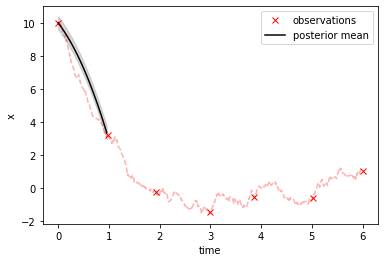

In [101]:
postmean = post_mean(true_sde.pts[:100])

plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde.pts[:100], postmean, color='black', label="posterior mean")
plt.plot(true_sde.pts,true_sde.trj, 'red', linestyle='dashed', alpha= 0.3)
plt.fill_between(true_sde.pts[:100], postmean - 0.5/r_, postmean + 0.5/r_, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [ ]:
beta_ = 1.
alpha_ = 0.
r_ = 1.
m0 = obs[3]

N = 50
N_e = 50
learning_rate = 0.0000001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    beta_grad = 0.
    alpha_grad = 0.
    r_grad = 0.

    for i in range(N):
        vi = tOU(t0 = obs_time[3], t1 = obs_time[4], z0 = obs[3], m0 = m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64)\
                                    , torch.tensor(m0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))
        f_of_X = -1 * (elbo.log_prob(obs[4]) + elbo.KL_ito() + elbo.KL_rest())
        beta_grad += f_of_X * scores['beta']
        alpha_grad += f_of_X * scores['alpha']
        r_grad += f_of_X * scores['r']
        
    beta_ -= learning_rate * (beta_grad/N).numpy()
    alpha_ -= learning_rate * (alpha_grad/N).numpy()
    r__ = r_ + learning_rate * (r_grad/N).numpy()
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ + lr * (r_grad/N).numpy()
        lr *= 0.5
    r_ = r__

    
    elbo_estimate = 0
    for j in range(N_e):
        vi_ = tOU(t0 = obs_time[3], t1=obs_time[4], z0 = obs[3], m0 = m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo_ = ELBO(vi_)
        elbo_estimate += -1 * (elbo_.log_prob(obs[4]) + elbo_.KL_ito() + elbo_.KL_rest())
    
    elbo_estimate *= 1/N_e
    
    if k % 100 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_, 'ELBO = ', elbo_estimate)
    
    trace_pars.append((beta_, alpha_, r_))
    trace_elbo.append(elbo_estimate)
# score.compute_score()

In [ ]:
for i in range(50):
    posterior = tOU(t0 = obs_time[3], t1 = obs_time[4], z0 = obs[3], m0 = obs[3], alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(posterior.pts, func(posterior.pts), 'd')
    plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

In [ ]:
post_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

In [ ]:
alpha_ * ((true_sde.pts[300:400] + 1) ** beta_ - 1) + m0

In [ ]:
toy_sde = tOU(3, 100, m0, m0, alpha_, beta_, 1., r_, dN = 30)
toy_sde_trj, toy_sde_dt = toy_sde.simulate()

In [ ]:
m0

In [ ]:
func = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

In [ ]:
plt.plot(toy_sde.pts, toy_sde_trj, 'rx', label = 'time-dependent OU')
plt.plot(toy_sde.pts, func(toy_sde.pts), linestyle='dashed', color='red', alpha=0.3, label='aymptotic mean')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [ ]:
postmean = post_mean(true_sde.pts[300:400])

plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde.pts[300:400], postmean, color='black', label="posterior mean")
plt.plot(true_sde.pts,true_sde.trj, 'red', linestyle='dashed', alpha= 0.3)
plt.fill_between(true_sde.pts[300:400], postmean - 0.5/r_, postmean + 0.5/r_, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

2. Complete piece-wise optimization from t=0 to t=10

We use the posterior mean of the previous step as our initial value for next vi

In [ ]:
N = 50
N_e = 50
learning_rate = 0.0000001
lr = learning_rate
z0 = obs[0]
IT = 100

elbo_traces = np.empty((9, IT))
pars_traces = np.empty((3, 9, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    beta_ = np.random.uniform(1, 3)
    alpha_ = 0.
    r_ = np.random.uniform(1, 2)
  
    for i in range(IT):
        beta_grad = 0.
        alpha_grad = 0.
        r_grad = 0.
        
        for k in range(N):
            vi = tOU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0, m0 = z0, alpha = alpha_ , beta = beta_ , sigma = 1., r = r_, dN=30)
            elbo = ELBO(vi)
            score = Score(vi)

            scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64)\
                            , torch.tensor(z0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))

            f_of_X = -1 * (elbo.log_prob(obs[t+1]) + elbo.KL_ito() + elbo.KL_rest())
            
            beta_grad += f_of_X * scores['beta']
            alpha_grad += f_of_X * scores['alpha']
            r_grad += f_of_X * scores['r']
            
        beta_ -= learning_rate * (beta_grad/N).numpy()
        alpha_ -= learning_rate * (alpha_grad/N).numpy()
        r__ = r_ + learning_rate * (r_grad/N).numpy()
    
        # It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ + lr * (r_grad/N).numpy()
            lr *= 0.5
        r_ = r__

        
        pars_traces[0, t, i] = alpha_
        pars_traces[1, t, i] = beta_
        pars_traces[2, t, i] = r_
        
        elbo_estimate = 0
        for j in range(N_e):
            vi_ = tOU(t0 = obs_time[t], t1=obs_time[t+1], z0 = z0, m0 = z0, alpha = alpha_, beta = beta_ , sigma = 1., r = r_, dN=30)
            elbo_ = ELBO(vi_)
            elbo_estimate += -1 * (elbo_.log_prob(obs[t+1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
        elbo_estimate *= 1/N_e
        if i % 10 == 0:
            print("alpha = ", alpha_, "beta = ", beta_, "r = ", r_, "elbo = ", elbo_estimate)
        elbo_traces[t, i] = elbo_estimate

    z0 +=  alpha_ * (((obs_time[t+1] + 1) ** np.mean(pars_traces[1, t, -30:])) - 1)
    
# score.compute_score()

Trace plot: ELBO

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :IT])), elbo_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(pars_traces[0, t, :IT])), pars_traces[0, t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("beta, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: beta")
plt.show()

In [ ]:
def g_posterior_moment(init, alpha, vi_beta, t0, t1):
    """
        Obtain credible interval
            posterior mean and variance are computed based on the theory (using fitted variational parameter at each interval)
    """
    sigma = 1.
    pts = np.linspace(t0,t1,900)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
    var = list(map(lambda t: np.sqrt((sigma ** 2 / (2*vi_beta[0])) * (1 - np.exp(-2 * vi_beta[0] * t))), dt[:100]))
    
    k = 0
    for j in range(dt.shape[0]):
        if j % 100 == 0:
            beta = vi_beta[k]
            k += 1
        mean.append(alpha + (mean[j] - alpha)*np.exp(-1 * beta * dt[j]))
        if (j % 100 == 0) and (j > 0):
            func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
            var += list(map(func, dt[j-100:j]))
    return np.array(mean), np.array(var)

In [ ]:
pmean, pvar = g_posterior_moment(obs[0], 0, vi_beta, 0, 6)

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Posterior process")
plt.plot(true_sde.pts, true_sde.trj, alpha=0.3, label='underlying SDE')
plt.plot(true_sde.pts[:900], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[:900], pmean - pvar, pmean + pvar, alpha=0.5, color='grey')
plt.plot(obs_time, obs, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()